# DAGGER - A toolkit to create and run computation graphs
The purpose of this library is to streamline the creation of a domain-specific calculation codebase.

Dagger was created because the process of reverse-engineering domain-specific calculations into a codebase is time-consuming and can be difficult to audit for anyone except the developers. This codebase is intended to streamline the creation of a python deterministic model from a list of calculations. Rapidly converting these to a graph makes the process of creating the model, auditing it and communicating results more streamlined, especially with a back-and-forth with a domain expert is required.

## How it works
There are two main classes: `GraphFactory` and `GraphRunner`. The former creates the graph structure, but does not run the model. The latter runs the model to run the computations and generate outputs.

Current entry points to `GraphFactory` include:
- (Implemented) A Python codebase with a class with multiple inter-dependent functions: one per calculation to be performed. Some function inputs include outputs of other functions
- (Coming Soon) Directly from an existing Excel file containing the calculations

In [1]:
from computation_graph import GraphFactoryPython, GraphRunner

# Entry Point: Python Code
As an example we will define a set of three functions in a class. We could execute these functions by first instantiating `RealEstateCalcs`, then invoking one of its methods. This will certainly work, if we know how to use the functions. Being able to define simple, straight-forward calculation steps as shown below is easy to maintain, easy to audit, and easy to test.

In [2]:
class RealEstateCalcs:
    """Real Estate Property Investment Calcs"""

    def property_taxes(tax_rate, purchase_price) -> float:
        return tax_rate * purchase_price
    
    def closing_costs(purchase_price, closing_costs_multiplier) -> float:
        return purchase_price * closing_costs_multiplier
    
    def total_equity_investment(tei_multiplier, purchase_price, closing_costs, renovations) -> float:
        return (tei_multiplier * (purchase_price + closing_costs + renovations))

    def loan_amount(purchase_price, closing_costs, total_equity_investment, renovations) -> float:
        return total_equity_investment + purchase_price + closing_costs + renovations

# GraphFactory

The `GraphFactory` class creates a graph from code. The code must meet these conditions:
- Each computation or formula for which an output should be inspected is a single public function (no leading underscore)
- Methods must be contained in a single class with no __init__ method
- Methods must be static (no input of `self` is supported at this point)
- Names for a method must match its corresponding argument in a downstream method (i.e., in the test example provided )

Since our `RealEstateCalcs` defined above does meet these conditions, we should be good to go.

In [3]:
# Create a graph from formulas in the class RealEstateFormulas
gf = GraphFactoryPython()
gf.build_graph_from_code(RealEstateCalcs)

## Visualize graph structure
Visualizing the graph is an excellent way to review and verify inter-dependencies between steps in the calculation. Using it as the code is developed can also serve as a code review tool, because it can highlight misnamings.

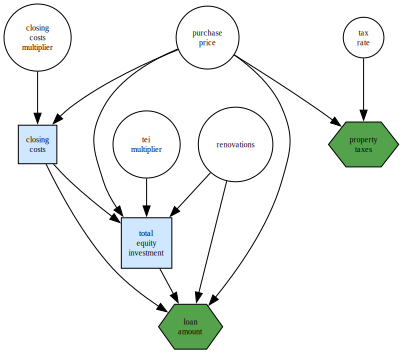

In [4]:
from visualization import visualize_graph_dot
# Visualize using pygraphviz (requires local Graphviz binaries on machine)
visualize_graph_dot(gf.G, fontsize=8, orienation="TB")

The graph is color-coded as follows:
- white circles: inputs only (in_degree=0). These have no functions
- blue squares: intermediate calculations (in_degree>0 and out_degree>0). These are not the final result but their outputs can be used for auditing
- green hexagons: terminal outputs (out_degree=0). These are the not used as inputs to other functions and are assumed to be outputs

# GraphRunner

`GraphRunner` is responsible for populating the graph with values and running the computations. It requires an instance of `GraphRunner` (the model structure) and a dict containing the inputs (one for each white node in the graph plot above). Again, naming is critical here. The dict key names must exactly match the corresponding method input in the code

In [5]:
from computation_graph import GraphRunner

In [6]:
# Run to confirm what inputs are needed
gf.get_nodes_by_role("input")

['purchase_price',
 'closing_costs_multiplier',
 'renovations',
 'tax_rate',
 'tei_multiplier']

In [7]:
# Create a dict where each input is accounted for as a key
# and the value type matches what is needed for the function. Any inputs without
# a matching method parameter will be ignored, but a userwarning will be
# given

inputs = dict(
    purchase_price = 300_000,
    closing_costs_multiplier = 0.02,
    renovations=15_000,
    tax_rate=0.12,
    down_payment = 65_000,
    tei_multiplier=0.05,
    my_name="Jonathan", # extraneous input ignored
)

model = GraphRunner(gf, inputs)

In [8]:
model.run()

c:\Users\jawne\Documents\DAGger\computation_graph.py:159: UserWarning: 'down_payment' was provided as an input but is not a node in the graph
  warnings.warn(
c:\Users\jawne\Documents\DAGger\computation_graph.py:159: UserWarning: 'my_name' was provided as an input but is not a node in the graph
  warnings.warn(


In [9]:
# To get calculated results, run this without arguments or pass a list of result names to get just those
model.query_results()

{'closing_costs': 6000.0,
 'loan_amount': 337050.0,
 'property_taxes': 36000.0,
 'total_equity_investment': 16050.0,
 'purchase_price': 300000,
 'closing_costs_multiplier': 0.02,
 'renovations': 15000,
 'tax_rate': 0.12,
 'tei_multiplier': 0.05}

In [10]:
from dataclasses import dataclass, field
from typing import Optional

@dataclass
class MonteCarloInput:

    node: str
    # min: Optional[float] = field(default=None)
    # max: Optional[float] = field(default=None)
    distribution: Optional[str] = field(default=None)
    uncertainty: Optional[float] = field(default=None)

x = MonteCarloInput(node='closing_costs_multiplier', uncertainty=0.1)
y = MonteCarloInput(node='tax_rate', uncertainty=0.05)
y = MonteCarloInput(node='renovations', uncertainty=0.2)


In [11]:
from monte_carlo import MonteCarlo

mc = MonteCarlo(model, [x, y], iterations=10_000)
mc_df = mc.make_mc_inputs()
mc_results = mc.run_mc(mc_df)

0.02
15000


c:\Users\jawne\Documents\DAGger\computation_graph.py:159: UserWarning: 'down_payment' was provided as an input but is not a node in the graph
  warnings.warn(
c:\Users\jawne\Documents\DAGger\computation_graph.py:159: UserWarning: 'my_name' was provided as an input but is not a node in the graph
  warnings.warn(


In [12]:
mc_results

,closing_costs_multiplier,renovations,results
0,0.021297,14742.673776,6389.195836
1,0.019967,12510.601182,5990.202423
2,0.020858,7578.635932,6257.287495
3,0.017724,18860.017919,5317.332508
4,0.020449,13798.338196,6134.578256
...,...,...,...
9995,0.019996,15778.906811,5998.814452
9996,0.021166,11005.265058,6349.919892
9997,0.018946,7663.516554,5683.679745
9998,0.021084,14090.588792,6325.117869


<Axes: >

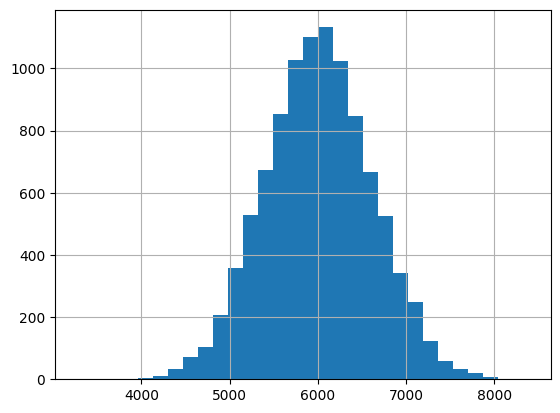

In [13]:
mc_results['results'].hist(bins=30)

In [14]:
from computation_graph import GraphFactoryExcel

# Entry Point: Excel

In [15]:
gf = GraphFactoryExcel()

mapping = {
    "'[Formula Test.xlsx]SHEET1'!B3": "purchase_price",
    "'[Formula Test.xlsx]SHEET1'!C3": "tei_multiplier",
    "'[Formula Test.xlsx]SHEET1'!D3": "tax_rate",
    "'[Formula Test.xlsx]SHEET1'!E3": "Renovations",
    "'[Formula Test.xlsx]SHEET1'!F3": "property_taxes",
    "'[Formula Test.xlsx]SHEET1'!G3": "closing_clsts_multiplier",
    "'[Formula Test.xlsx]SHEET1'!H3": "closing_costs",
    "'[Formula Test.xlsx]SHEET1'!I3": "total_equity_investment",
    "'[Formula Test.xlsx]SHEET1'!J3": "loan_amount",
}

gf.build_dag_from_excel('Formula Test.xlsx', mapping)
gf.remove_island_nodes()

0it [00:00, ?it/s]


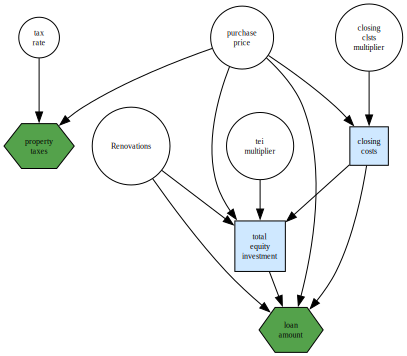

In [17]:
visualize_graph_dot(gf.G, orienation="TB")

In [ ]:
import networkx as nx

def relabel_nodes(mapping_dict):

nx.relabel_nodes(gf.G, mapping, copy=False)

IndentationError: expected an indented block after function definition on line 3 (1013873649.py, line 7)

In [ ]:
for node in gf.G.nodes:
    print(node)

'[Formula Test.xlsx]SHEET1'!B2
'[Formula Test.xlsx]SHEET1'!C2
'[Formula Test.xlsx]SHEET1'!D2
'[Formula Test.xlsx]SHEET1'!E2
'[Formula Test.xlsx]SHEET1'!F2
'[Formula Test.xlsx]SHEET1'!G2
'[Formula Test.xlsx]SHEET1'!H2
'[Formula Test.xlsx]SHEET1'!I2
'[Formula Test.xlsx]SHEET1'!J2
purchase_price
tei_multiplier
tax_rate
Renovations
closing_clsts_multiplier
property_taxes
closing_costs
total_equity_investment
loan_amount
